In [26]:
%matplotlib inline
from scipy.ndimage.filters import gaussian_filter
from brian2 import *
from ipywidgets import interact, interactive, fixed
import ipywidgets
import numpy as np
from collections import OrderedDict
import matplotlib.cm as cm
import matplotlib.colors as colors

In [27]:
def nan_gaussian_filter(x, sigma, num_passes):
    z = full_like(x, nan)
    for cursigma in linspace(sigma, 0, num_passes + 1)[:-1]:
        y = gaussian_filter(x, cursigma, mode='nearest')
        z[isnan(z)] = y[isnan(z)]
    return z

In [28]:
def sim(tau, t_ref, fr_exc, alpha,  beta, fr_inh, quality, max_mu, max_sigma):
    start_scope()

    if quality == 0:
        N = 15
        duration = 50 * ms
        skip_time = 25 * ms
        blur_width = 0.05
        N_syn_exc = 20  # Max number of excitatory inputs
        N_w_exc = 20  # Max number of different input weights tested
    elif quality == 1:
        N = 20
        duration = 100 * ms
        skip_time = 50 * ms
        blur_width = 0.1
        N_syn_exc = 25  # Max number of excitatory inputs
        N_w_exc = 25  # Max number of different input weights tested
    elif quality == 2:
        N = 30
        duration = 250 * ms
        skip_time = 50 * ms
        blur_width = 0.1
        N_syn_exc = 30  # Max number of excitatory inputs
        N_w_exc = 30  # Max number of different input weights tested
    elif quality == 3:
        N = 40
        duration = 800 * ms
        skip_time = 100 * ms
        blur_width = 0.05
        N_syn_exc = 30  # Max number of excitatory inputs
        N_w_exc = 30  # Max number of different input weights tested

    # Excitatory Parameters

    max_syn_exc = 80
    sy_exc_v = np.linspace(0, max_syn_exc, N_syn_exc)
    w_exc_v = np.linspace(0, (max_sigma ** 2) / max_mu, N_w_exc)

    tau = tau * ms
    t_ref = t_ref * ms
    n_mu = w_exc_v.size
    n_sigma = sy_exc_v.size


    # Equation for each Cell
    eqs = '''
    dv/dt = (mu-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
    mu : 1
    sigma: 1
    '''

    # Simulation for  N*n_mu*n_sigma cells for each possible combination of sigma and mu
    G = NeuronGroup(N*n_mu*n_sigma, eqs, threshold='v>1', reset='v=0', refractory=t_ref, method='euler')
    M = SpikeMonitor(G)

    w_exc = np.tile(w_exc_v, sy_exc_v.size * N)
    sy_exc = np.repeat(sy_exc_v, w_exc_v.size * N)
    sy_inh = sy_exc * alpha
    w_inh = w_exc * beta

    G.mu = np.asarray(tau * ((w_exc * sy_exc * fr_exc) - (w_inh * sy_inh * fr_inh)))
    G.sigma = np.sqrt(np.asarray(tau * (w_exc ** 2 * sy_exc * fr_exc + w_inh ** 2 * sy_inh * fr_inh)))

    run(duration)

    # Results Analysis
    SpikeTrains = M.spike_trains()
    CV_v = np.zeros((N*n_mu*n_sigma))
    FR_v = np.zeros((N*n_mu*n_sigma))

    #   Obtain CV value for each simulated Cell and store them in CV_v vector
    for index in range(N*n_mu*n_sigma):
        T = SpikeTrains[index]
        T = T[T > skip_time]
        SpikeTrains[index] = np.diff(np.sort(T))
        CV_v[index] = divide(np.std(SpikeTrains[index]), np.mean(SpikeTrains[index]))
        FR_v[index] = np.size(T) / (duration-skip_time)

        # Store the CV-averaged value in a matrix CV[i, j]
        # where i is the index of G.mu and j the index ofG.sigma
    CV = np.zeros((n_mu, n_sigma))
    FR = np.zeros((n_mu, n_sigma))
    tmp_CV = 0
    tmp_FR = 0

    for i in range(n_mu):
        for j in range(n_sigma):
            for k in range(N):
                tmp_CV += CV_v[i*n_sigma*N+j+k*n_sigma]
                tmp_FR += FR_v[i*n_sigma*N+j+k*n_sigma]
            CV[i, j] = tmp_CV/N
            FR[i, j] = tmp_FR/N
            tmp_CV = 0
            tmp_FR = 0

    # Graph Axis
    max_sy = amax(sy_exc_v)
    min_sy = amin(sy_exc_v)
    max_w = amax(w_exc_v)
    min_w = amin(w_exc_v)

    plot_CV(CV, FR, min_sy, max_sy, min_w, max_w, blur_width)
    return

In [29]:
def plot_CV(CV, FR, min_sy, max_sy, min_w, max_w, blur_width):
    # plt.figure(1)
    ax = plt.gca()
    ax.set_axis_bgcolor('grey')
    CV = nan_gaussian_filter(CV, blur_width*CV.shape[0], 10)
    im = plt.imshow(CV, interpolation='nearest', origin='lower left', aspect='auto',
                    cmap=cm.YlGnBu_r, extent=(min_w, max_w, min_sy, max_sy), norm=colors.Normalize(0, 1))
    # ylabel(r'$\Number of Excitatory Inputs$')
    # xlabel(r'$\Average excitatory input weight/\mu$')

    levels_CV = np.array([0.35, 0.8])
    CS = plt.contour(CV, levels_CV,
                     origin='lower',
                     linewidths=2,
                     extent=(min_w, max_w, min_sy, max_sy))
    plt.clabel(CS, levels_CV[0:2],
               inline=1,
               fmt='%1.1f',
               fontsize=14)

    levels_FR = np.array([50, 400])
    CS = plt.contour(FR, levels_FR,
                     origin='lower',
                     linewidths=2,
                     extent=(min_w, max_w, min_sy, max_sy),
                     linestyles='dashed')
    plt.clabel(CS, levels_FR[0:2],
               inline=1,
               fmt='%1.1f',
               fontsize=14)

    # make a colorbar for the image
    cb = plt.colorbar(im, orientation='horizontal', shrink=0.8)
    cb.set_label('CV', rotation=270, labelpad=20)
    return

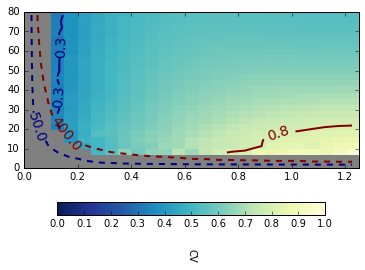

In [30]:
interact(sim,
             tau=ipywidgets.FloatSlider(value=5, min=0.1, max=20, step=0.1, continuous_update=False,
                                        description=r"$\tau$ (ms)"),
             t_ref=ipywidgets.FloatSlider(value=0.1, min=0, max=5, step=0.1, continuous_update=False,
                                          description=r"refractory (ms)"),
             fr_exc=ipywidgets.FloatSlider(value=50, min=0, max=400, step=50, continuous_update=False,
                                          description=r"Excitatory Firing rate"),
             alpha=ipywidgets.FloatSlider(value=0.2, min=0, max=1, step=0.1, continuous_update=False,
                                          description=r"Alpha"),
             beta=ipywidgets.FloatSlider(value=2, min=0, max=8, step=0.5, continuous_update=False,
                                         description=r"Beta"),
             fr_inh=ipywidgets.FloatSlider(value=50, min=0, max=400, step=50, continuous_update=False,
                                           description=r"Inhibitory Firing Rate"),
             quality=ipywidgets.Dropdown(options=OrderedDict([('Very fast', 0),
                                                              ('Fast', 1),
                                                              ('Medium', 2),
                                                              ('High / slow', 3)]),
                                         value=1, description="Quality"),
             max_mu=5,
             max_sigma=2.5
             );